# How to Win a Data Science Competition: Learn from Top Kagglers
This is the notebook for the final project of the coursera. All packages used are reported in requirements.txt file in the current directory

importing libraries

In [1]:
import numpy as np
import pandas as pd
import time, sys, gc, pickle

from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Loading all the data

In [2]:
train = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("competitive-data-science-predict-future-sales/test.csv")
cats = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
sample_sub = pd.read_csv("competitive-data-science-predict-future-sales/sample_submission.csv")

# EDA

Checking the data

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
len(train), train.shop_id.nunique(), train.item_id.nunique(), train.date_block_num.min(), train.date_block_num.max()

(2935849, 60, 21807, 0, 33)

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [8]:
len(train), train.shop_id.nunique(), train.item_id.nunique()

(2935849, 60, 21807)

There are 2935848 transactions in the trainig set and 214200 in the test set. There are 60x21807 unique pairs of shop-item objects sold in the past 34 months. We need to generate a prediction of of future sells of such objects for the 35th month.

Let's see if there are outliners.

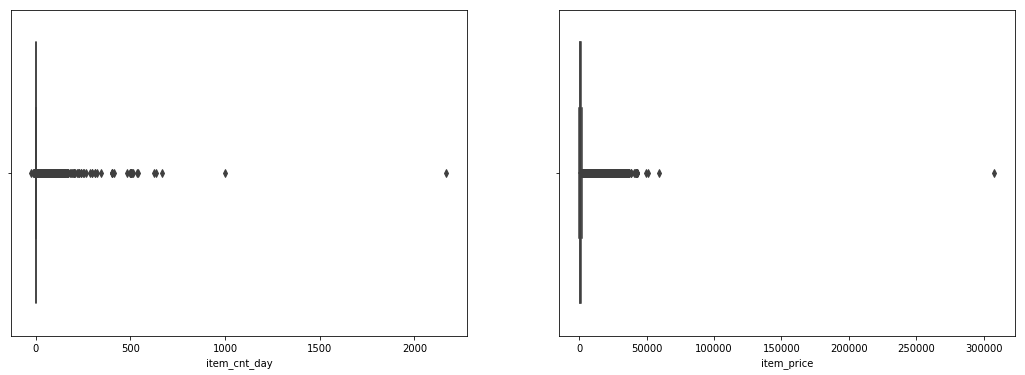

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.boxplot(x=train.item_cnt_day, ax=axes[0])
sns.boxplot(x=train.item_price, ax=axes[1])

In [10]:
# remove outliers
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [11]:
# moreover, there is one object with item_price lower than 0. replace it with the median
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

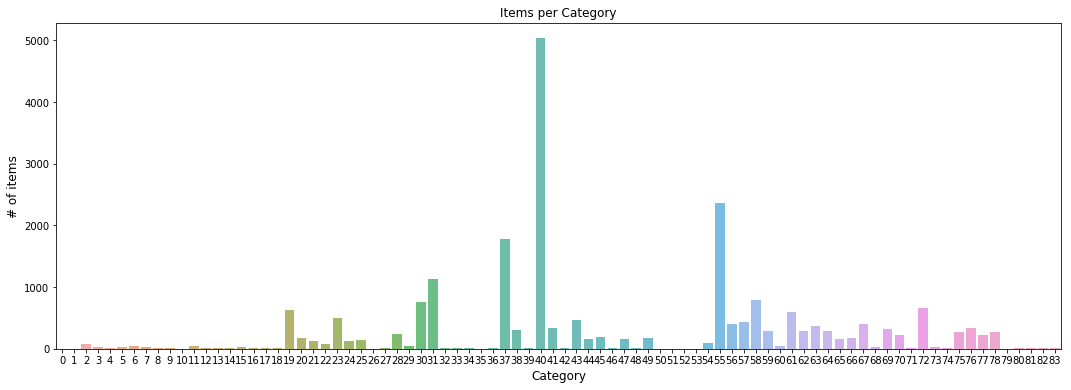

In [12]:
# Which category has the higher number of items?
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.reset_index()
fig, ax = plt.subplots(figsize=(18,6))
ax=sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

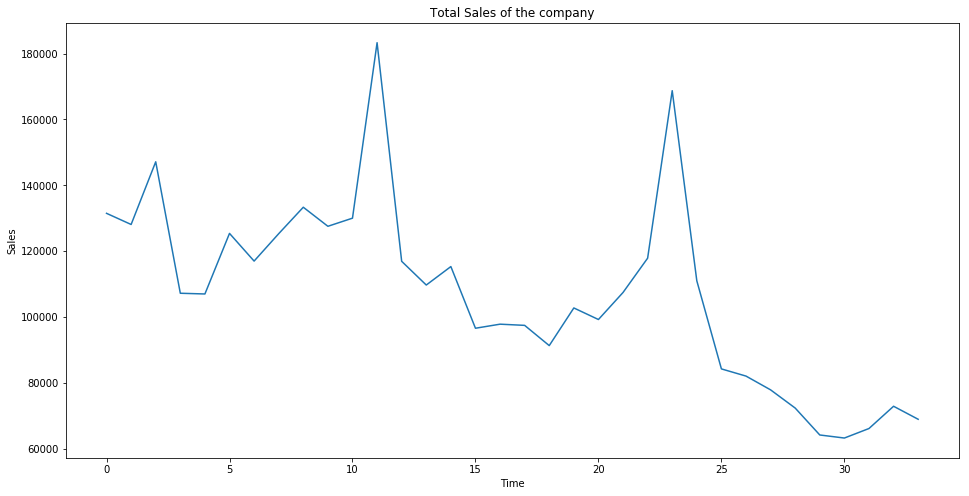

In [13]:
#Let's plot the total sales for each month. 
ts=train.groupby(["date_block_num"])["item_cnt_day"].sum()
fig, ax = plt.subplots(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
ax.plot(ts)

# Investigation for data leaks

We can find the mean of the target variable on the public leaderboard by probing it with a submition of all 0 and an other one with all 1.
The public score of the first one is 1.25011 (all zeros= mse_0)
The public score of the second one is 1.41241 (all ones= mse_1)
The resulting mean target value for the public leader board is 0.2839. We must check at the end of our final submition to have a similar value

In [14]:
N = 214200.
mse_0 = 1.25011**2
mse_1 = 1.41241**2
sum_y_true = ((mse_1 * N) - (mse_0 * N) - N) / -2.
mean_y_true = sum_y_true / N
print(mean_y_true)

0.28393650200000026


# Feature Engineering
Let's create some features. we need to organize the train set as in the test set.

In [15]:
t = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - t

15.740506887435913

In [16]:
matrix.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [17]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')

In [18]:
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20)

In [19]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [20]:
#lets join train and test set
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

adding some categorical features: item_category_id, month, days per month

In [21]:
matrix = pd.merge(matrix, items.drop("item_name", axis=1), on=['item_id'], how='left')
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

adding lag features

In [23]:
#convinient function for creating lag features
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [24]:
# creating lag features
t = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - t

44.90112781524658

In [25]:
matrix.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,0.0,40,0,31,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,19,0,31,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,30,0,31,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,23,0,31,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,40,0,31,NaN,NaN,NaN,NaN,NaN
5,0,0,33,3.0,0.0,37,0,31,NaN,NaN,NaN,NaN,NaN
6,0,0,34,0.0,0.0,40,0,31,NaN,NaN,NaN,NaN,NaN
7,0,0,35,1.0,0.0,40,0,31,NaN,NaN,NaN,NaN,NaN
8,0,0,40,0.0,0.0,57,0,31,NaN,NaN,NaN,NaN,NaN
9,0,0,41,0.0,0.0,57,0,31,NaN,NaN,NaN,NaN,NaN


Mean Encoded Features (and related lag features). I am currently not using mean features of the current month but of previous ones (as defined in the lag).

In [26]:
# creating mean encoded features
t = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'month_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['month_avg_item_cnt'] = matrix['month_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'month_avg_item_cnt')
matrix.drop(['month_avg_item_cnt'], axis=1, inplace=True)
time.time() - t

17.92462396621704

In [27]:
t = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'month_itemid_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['month_itemid_avg_item_cnt'] = matrix['month_itemid_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'month_itemid_avg_item_cnt')
matrix.drop(['month_itemid_avg_item_cnt'], axis=1, inplace=True)
time.time() - t

56.17659091949463

In [28]:
t = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'month_shopid_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['month_shopid_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'month_shopid_avg_item_cnt')
matrix.drop(['month_shopid_avg_item_cnt'], axis=1, inplace=True)
time.time() - t

61.045785903930664

In [29]:
t = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'month_catid_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['month_catid_avg_item_cnt'] = matrix['month_catid_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'month_catid_avg_item_cnt')
matrix.drop(['month_catid_avg_item_cnt'], axis=1, inplace=True)
time.time() - t

26.995256900787354

In [30]:
t = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['month_shopid_catid_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['month_shopid_catid_avg_item_cnt'] = matrix['month_shopid_catid_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'month_shopid_catid_avg_item_cnt')
matrix.drop(['month_shopid_catid_avg_item_cnt'], axis=1, inplace=True)
time.time() - t

31.294289112091064

In [31]:
t = time.time()
train['revenue'] = train['item_price'] *  train['item_cnt_day']
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['monthly_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['monthly_shop_revenue'] = matrix['monthly_shop_revenue'].astype(np.float32)
matrix = lag_feature(matrix, [1,2,3,6], 'monthly_shop_revenue')

matrix.drop(['monthly_shop_revenue'], axis=1, inplace=True)
time.time() - t

58.63926601409912

In [32]:
t = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - t

5.22210693359375

In [33]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_category_id', 'month', 'days', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'month_avg_item_cnt_lag_1',
       'month_itemid_avg_item_cnt_lag_1', 'month_itemid_avg_item_cnt_lag_2',
       'month_itemid_avg_item_cnt_lag_3', 'month_itemid_avg_item_cnt_lag_6',
       'month_itemid_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt',
       'month_shopid_avg_item_cnt_lag_1', 'month_shopid_avg_item_cnt_lag_2',
       'month_shopid_avg_item_cnt_lag_3', 'month_shopid_avg_item_cnt_lag_6',
       'month_shopid_avg_item_cnt_lag_12', 'month_catid_avg_item_cnt_lag_1',
       'month_shopid_catid_avg_item_cnt_lag_1', 'monthly_shop_revenue_lag_1',
       'monthly_shop_revenue_lag_2', 'monthly_shop_revenue_lag_3',
       'monthly_shop_revenue_lag_6'],
      dtype='object')

In [34]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 31 columns):
date_block_num                           int8
shop_id                                  int8
item_id                                  int16
item_cnt_month                           float64
ID                                       float64
item_category_id                         int8
month                                    int8
days                                     int8
item_cnt_month_lag_1                     float64
item_cnt_month_lag_2                     float64
item_cnt_month_lag_3                     float64
item_cnt_month_lag_6                     float64
item_cnt_month_lag_12                    float64
month_avg_item_cnt_lag_1                 float16
month_itemid_avg_item_cnt_lag_1          float16
month_itemid_avg_item_cnt_lag_2          float16
month_itemid_avg_item_cnt_lag_3          float16
month_itemid_avg_item_cnt_lag_6          float16
month_itemid_avg_ite

In [35]:
# don't dowcast below float32
#float_cols = [c for c in matrix if matrix[c].dtype in ["float32","float64"]]
#int_cols =   [c for c in matrix if matrix[c].dtype in ["int64", "int32"]]
#matrix[float_cols] = matrix[float_cols].astype(np.float16)
#matrix[int_cols]   = matrix[int_cols].astype(np.int16)

In [36]:
matrix.to_pickle('data_matrix.pkl')
del matrix
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect()

16120

# Models

In this section I will create different models:
XGboost, Random Forest, Linear Regression, Neural Networls.
In the following I will stack all the outcome of such models for a better prediction.
All such models are serialized to disk and can be loaded without having to train them.

In [37]:
data = pd.read_pickle('data_matrix.pkl')

In [38]:
data = data.replace([np.inf], np.nan)

In [39]:
data.fillna(0, inplace=True)
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,...,month_shopid_avg_item_cnt_lag_2,month_shopid_avg_item_cnt_lag_3,month_shopid_avg_item_cnt_lag_6,month_shopid_avg_item_cnt_lag_12,month_catid_avg_item_cnt_lag_1,month_shopid_catid_avg_item_cnt_lag_1,monthly_shop_revenue_lag_1,monthly_shop_revenue_lag_2,monthly_shop_revenue_lag_3,monthly_shop_revenue_lag_6
0,0,0,19,0.0,0.0,40,0,31,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,27,0.0,0.0,19,0,31,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,28,0.0,0.0,30,0,31,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,29,0.0,0.0,23,0,31,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,32,6.0,0.0,40,0,31,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_category_id', 'month', 'days', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'month_avg_item_cnt_lag_1',
       'month_itemid_avg_item_cnt_lag_1', 'month_itemid_avg_item_cnt_lag_2',
       'month_itemid_avg_item_cnt_lag_3', 'month_itemid_avg_item_cnt_lag_6',
       'month_itemid_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt',
       'month_shopid_avg_item_cnt_lag_1', 'month_shopid_avg_item_cnt_lag_2',
       'month_shopid_avg_item_cnt_lag_3', 'month_shopid_avg_item_cnt_lag_6',
       'month_shopid_avg_item_cnt_lag_12', 'month_catid_avg_item_cnt_lag_1',
       'month_shopid_catid_avg_item_cnt_lag_1', 'monthly_shop_revenue_lag_1',
       'monthly_shop_revenue_lag_2', 'monthly_shop_revenue_lag_3',
       'monthly_shop_revenue_lag_6'],
      dtype='object')

In [41]:
# I will use currently only the following features.
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'item_category_id',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'month_avg_item_cnt_lag_1',
    'month_itemid_avg_item_cnt_lag_1',
    'month_itemid_avg_item_cnt_lag_2',
    'month_itemid_avg_item_cnt_lag_3',
    'month_itemid_avg_item_cnt_lag_6',
    'month_itemid_avg_item_cnt_lag_12',
    'month_shopid_avg_item_cnt_lag_1',
    'month_shopid_avg_item_cnt_lag_2',
    'month_shopid_avg_item_cnt_lag_3',
    'month_shopid_avg_item_cnt_lag_6',
    'month_shopid_avg_item_cnt_lag_12',
    'month_catid_avg_item_cnt_lag_1',
    'monthly_shop_revenue_lag_1',
    'month',
    'days',
]]

In [42]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [43]:
del data
gc.collect()

7

In [44]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [45]:
# In this cell I report the code to hypertune xgboost parameters
# It takes a long time to run, at least in my pc. so I decided to skip it and 
# use parameters that others find to be good for such a problem


#from sklearn import preprocessing
#import xgboost as xgb
#from xgboost.sklearn import XGBRegressor
#import datetime
#from sklearn.model_selection import GridSearchCV
#
#now = datetime.datetime.now()
#
#xgb1 = XGBRegressor()
#parameters = {'nthread':[4],
#              'objective':['reg:linear'],
#              'learning_rate': [.03, 0.05, .07], #so called `eta` value
#              'max_depth': [5, 6, 7],
#              'min_child_weight': [4],
#              'silent': [1],
#              'subsample': [0.7],
#              'colsample_bytree': [0.7],
#              'n_estimators': [500]}
#
#xgb_grid = GridSearchCV(xgb1,
#                        parameters,
#                        cv = 2,
#                        n_jobs = 2, # number of jobs to run in parallel
#                        verbose=True)
#
#xgb_grid.fit(X_train, 
#          Y_train, 
#          eval_metric="rmse",
#          eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
#          verbose=True, 
#          early_stopping_rounds = 10 )
#
#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

In [46]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[18:31:19] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.19211	validation_1-rmse:1.12466
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1515	validation_1-rmse:1.09468
[2]	validation_0-rmse:1.1179	validation_1-rmse:1.06896
[3]	validation_0-rmse:1.08871	validation_1-rmse:1.0477
[4]	validation_0-rmse:1.06407	validation_1-rmse:1.0303
[5]	validation_0-rmse:1.04341	validation_1-rmse:1.015
[6]	validation_0-rmse:1.02609	validation_1-rmse:1.00306
[7]	validation_0-rmse:1.01162	validation_1-rmse:0.992773
[8]	validation_0-rmse:0.999782	validation_1-rmse:0.984659
[9]	validation_0-rmse:0.989493	validation_1-rmse:0.977717
[10]	validation_0-rmse:0.979662	validation_1-rmse:0.972094
[11]	validation_0-rmse:0.9724	validation_1-rmse:0.9

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=True, subsample=0.8)

In [47]:
xgb_train_pred = model.predict(X_train).clip(0, 20)
xgb_valid_pred = model.predict(X_valid).clip(0, 20)
xgb_test_pred  = model.predict(X_test).clip(0, 20)

# save prediction model
filename = 'xgb_model.sav'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
#xgb_model = pickle.load(open(filename, 'rb'))

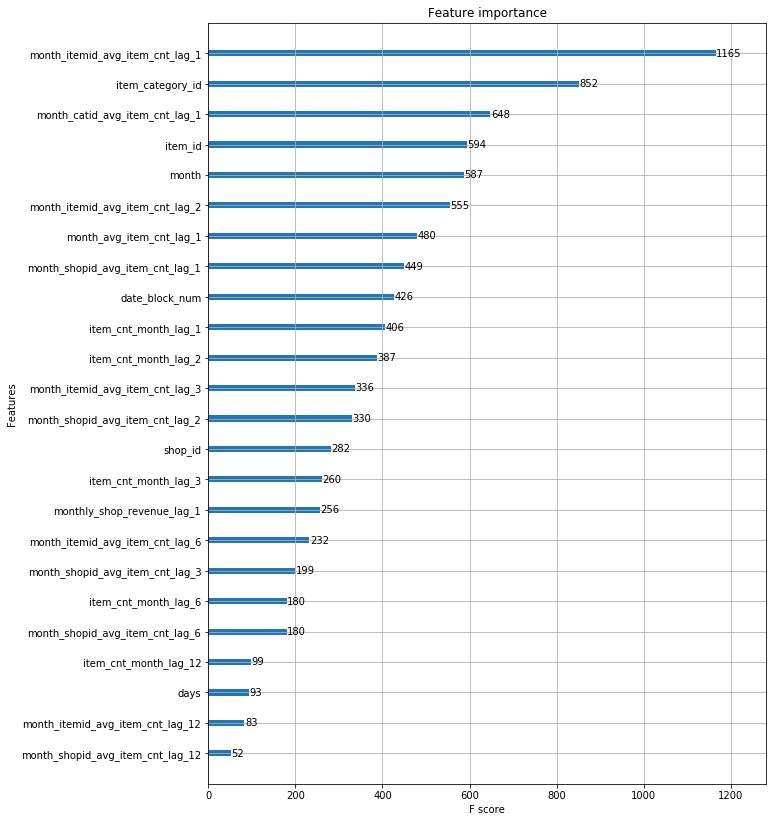

In [48]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))

In [49]:
from sklearn.metrics import mean_squared_error
rmsd_train = np.sqrt(mean_squared_error(Y_train, xgb_train_pred))
rmsd_valid = np.sqrt(mean_squared_error(Y_valid, xgb_valid_pred))
print("rmsd_train: ",rmsd_train)
print("rmsd_valid: ",rmsd_valid)

rmsd_train:  0.9001232774810063
rmsd_valid:  0.9360657827205278


In [57]:
# random forest model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(criterion='mse', n_estimators=100, max_depth=8, verbose=1, n_jobs=-1)
rf_model.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 48.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [58]:
rf_train_pred = rf_model.predict(X_train).clip(0, 20)
rf_valid_pred = rf_model.predict(X_valid).clip(0, 20)
rf_test_pred  = rf_model.predict(X_test).clip(0, 20)

# save prediction model
filename = 'rf_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

# load the model from disk
#rf_model = pickle.load(open(filename, 'rb'))
rmsd_train = np.sqrt(mean_squared_error(Y_train, rf_train_pred))
rmsd_valid = np.sqrt(mean_squared_error(Y_valid, rf_valid_pred))
print("rmsd_train: ",rmsd_train)
print("rmsd_valid: ",rmsd_valid)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


rmsd_train:  0.9493383328619186
rmsd_valid:  0.9768206514083572


In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train)
lr_train = lr_scaler.transform(X_train)
lr_valid = lr_scaler.transform(X_valid)
lr_test  = lr_scaler.transform(X_test)

lr_model = LinearRegression(n_jobs=-1, normalize=True)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [52]:
lr_train_pred = lr_model.predict(lr_train)
lr_valid_pred = lr_model.predict(lr_valid)
lr_test_pred = lr_model.predict(lr_test)

# save prediction model
filename = 'lr_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

# load the model from disk
#lr_model = pickle.load(open(filename, 'rb'))
rmsd_train = np.sqrt(mean_squared_error(Y_train, lr_train_pred))
rmsd_valid = np.sqrt(mean_squared_error(Y_valid, lr_valid_pred))
print("rmsd_train: ",rmsd_train)
print("rmsd_valid: ",rmsd_valid)

rmsd_train:  0.9782437747780725
rmsd_valid:  0.969255094335659


In [53]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

k_scaler = StandardScaler()
k_scaler.fit(X_train)
k_train = k_scaler.transform(X_train)
k_valid = k_scaler.transform(X_valid)
k_test  = k_scaler.transform(X_test)


Using TensorFlow backend.


In [54]:
model = Sequential()
model.add(Dense(20, input_dim=k_train.shape[1], kernel_initializer='uniform', activation='softplus'))
model.add(Dense(10, kernel_initializer='uniform', activation='softplus'))
model.add(Dense(1, kernel_initializer='uniform', activation = 'relu'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(k_train, Y_train, validation_data=(k_valid, Y_valid), verbose=1, epochs=100, batch_size = 64000, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 10675632 samples, validate on 238172 samples
Epoch 1/100
10675632/10675632 [==============================] - 13s 1us/step - loss: 1.2885 - mean_squared_error: 1.2885 - val_loss: 0.9945 - val_mean_squared_error: 0.9945
Epoch 2/100
10675632/10675632 [==============================] - 12s 1us/step - loss: 1.0316 - mean_squared_error: 1.0316 - val_loss: 0.9443 - val_mean_squared_error: 0.9443
Epoch 3/100
10675632/10675632 [==============================] - 13s 1us/step - loss: 0.9767 - mean_squared_error: 0.9767 - val_loss: 0.9407 - val_mean_squared_error: 0.9407
Epoch 4/100
10675632/10675632 [==============================] - 12s 1us/step - loss: 0.9633 - mean_squared_error: 0.9633 - val_loss: 0.9409 - val_mean_squared_error: 0.9409
Epoch 5/100
10675632/10675632 [==============================] - 12s 1us/step - loss: 0.9582 - mean_squared_error: 0.9582 - val_lo

In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("keras_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("keras_model.h5")
print("Saved model to disk")

# #load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# #load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

ke_train_pred = model.predict(k_train).clip(0, 20)
ke_valid_pred = model.predict(k_valid).clip(0, 20)
ke_test_pred  = model.predict(k_test ).clip(0, 20)

Saved model to disk


In [56]:
rmsd_train = np.sqrt(mean_squared_error(Y_train, ke_train_pred))
rmsd_valid = np.sqrt(mean_squared_error(Y_valid, ke_valid_pred))
print("rmsd_train: ",rmsd_train)
print("rmsd_valid: ",rmsd_valid)

rmsd_train:  0.9567405105746053
rmsd_valid:  0.9627721208680589


# Stacking

In [59]:
first_level = pd.DataFrame(xgb_valid_pred, columns=['xgb_valid_pred'])
first_level['random_forest'] = rf_valid_pred
first_level['linear_regression'] = lr_valid_pred
first_level['keras'] = ke_valid_pred
first_level.head()

,xgb_valid_pred,random_forest,linear_regression,keras
0,0.013530,0.049946,0.002786,0.000000
1,0.057445,0.049946,-0.093293,0.000000
2,0.218300,0.299687,0.241091,0.290494
3,0.296320,0.313934,0.550439,0.464226
4,0.000000,0.210763,0.237018,0.000000


In [60]:
meta_model = LinearRegression(n_jobs=-1)
meta_model.fit(first_level, Y_valid)

# save prediction model
filename = 'meta_model.sav'
pickle.dump(meta_model, open(filename, 'wb'))

# load the model from disk
#meta_model = pickle.load(open(filename, 'rb'))

In [61]:
first_level_test = pd.DataFrame(xgb_test_pred, columns=['xgb_test_pred'])
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['keras'] = ke_test_pred
Y_test = meta_model.predict(first_level_test).clip(0,20)

In [62]:
# adjusting by the leacked mean
leack_mean = 0.2839365
Y_test = Y_test + (-Y_test.mean() + leack_mean)

In [63]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('final_submission.csv', index=False)